In [1]:
import proplot as pplt
import numpy as np
import yaml
import glob
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "DEBUG"))

In [10]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect

cfg_yaml = """\
shear:
  scene: True

  # these keys are used to build paired sims w/ noise cancellation
  g: 0.02
  swap12: False

  # set these to run a sim directly
  g1: 0.02
  g2: 0.00

msk:
  cosmic_rays: False
  bad_columns: False
  streaks: False

coadd:
  central_size: 475
  buffer_size: 25
  scale: 0.2

se:
  n_images: 1
  wcs_config:
    position_angle_range: [0, 0]
    dither_scale: 0  # set to an odd number of pixels
    scale: 0.263
    scale_frac_std: 0
    shear_std: 0

psf:
  type: wldeblend
  fwhm_frac_std: 0.0
  shear_std: 0.0
  shear: [0, 0]

layout:
  type: random
  ngal_per_side: 10
  ngal_per_arcmin2: 60
  dither_scale: 0.263

gal:
  type: lsst-riz

star:
  dens_factor: 1
  rad_dist: uniform
  interp:
    skip: True
    # these control how the interpolation is applied for star holes
    # if fill_isolated_with_noise is True, then any missing pixel with no non-missing
    # pixels within iso_buff will be filled with noise and then used to interpolate
    # the rest of the pixels.
    iso_buff: 1
    fill_isolated_with_noise: False
  apodize:
    skip: False
    ap_rad: 1
  mask_expand_rad: 16

pizza_cutter:
  skip: False
  single_epoch_config:
    # pixel spacing for building various WCS interpolants
    se_wcs_interp_delta: 10
    coadd_wcs_interp_delta: 25
    frac_buffer: 1.42  # buffer around SE image to account for position angle rotations

    reject_outliers: False
    symmetrize_masking: True
    copy_masked_edges: False
    max_masked_fraction: 1.1
    edge_buffer: 8
    mask_tape_bumps: False

    # set the interp flags to 0 or 3 or 7 to interp stuff in the mask
    spline_interp_flags:
      - 7
    noise_interp_flags:
      - 0

    # always zero
    bad_image_flags:
      - 0

metadetect:
  metacal:
    psf: fitgauss
    types: [noshear, 1p, 1m, 2p, 2m]
    use_noise_image: True

  psf:
    lm_pars:
      maxfev: 2000
      ftol: 1.0e-05
      xtol: 1.0e-05
    model: gauss

    # we try many times because if this fails we get no psf info
    # for the entire patch
    ntry: 10

  sx:

  weight:
    fwhm: 1.2  # arcsec

  meds:
    box_padding: 2
    box_type: iso_radius
    max_box_size: 64
    min_box_size: 32
    rad_fac: 2
    rad_min: 4

  maskflags: 33554432  # 2**25 = BMASK_GAIA_STAR from pizza cutter

  # check for an edge hit
  bmask_flags: 1610612736  # 2**29 || 2**30
"""

cfg = yaml.safe_load(cfg_yaml)

In [11]:
import tqdm

big_rng = np.random.RandomState(seed=101)
star_seed = big_rng.randint(low=1, high=2**29)
gal_seed = big_rng.randint(low=1, high=2**29)

results = {}
for b in tqdm.tqdm(["g", "r", "i"]):
    cfg["gal"]["type"] = "lsst-%s" % b
    seeds = big_rng.randint(low=1, high=2**29, size=5)
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=gal_seed)
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])
    star_rng = np.random.RandomState(seed=star_seed)

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
        star_rng=star_rng,
        skip_coadding=False,
        star_config=cfg["star"],        
    )
    
    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            img=data["img"],
            wgt=data["wgt"],
            msk=data["msk"],
            bkg=data["bkg"],
            info=data["info"],
            n_extra_noise_images=0,
        )
    results[b] = {"se": data, "coadd": cdata}

  0%|                                                                                                                                               | 0/3 [00:00<?, ?it/s]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=446.0, y=446.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:wldeblend psf config: {'type': 'Kolmogorov', 'fwhm': 0.85, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:wldeblend galsim psf: galsim.Kolmogorov(lam_over_r0=0.8710235202553931).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'random' layout
DEBUG:pizza_cutter_sims.stars:generating 3 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.d

 33%|█████████████████████████████████████████████                                                                                          | 1/3 [00:56<01:53, 56.77s/it]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=446.0, y=446.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:wldeblend psf config: {'type': 'Kolmogorov', 'fwhm': 0.85, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:wldeblend galsim psf: galsim.Kolmogorov(lam_over_r0=0.8710235202553931).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'random' layout
DEBUG:pizza_cutter_sims.stars:generating 3 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.d

 67%|██████████████████████████████████████████████████████████████████████████████████████████                                             | 2/3 [01:41<00:49, 49.65s/it]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=446.0, y=446.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:wldeblend psf config: {'type': 'Kolmogorov', 'fwhm': 0.85, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:wldeblend galsim psf: galsim.Kolmogorov(lam_over_r0=0.8710235202553931).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'random' layout
DEBUG:pizza_cutter_sims.stars:generating 3 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.d

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.57s/it]


(-0.5, 524.5, 524.5, -0.5)

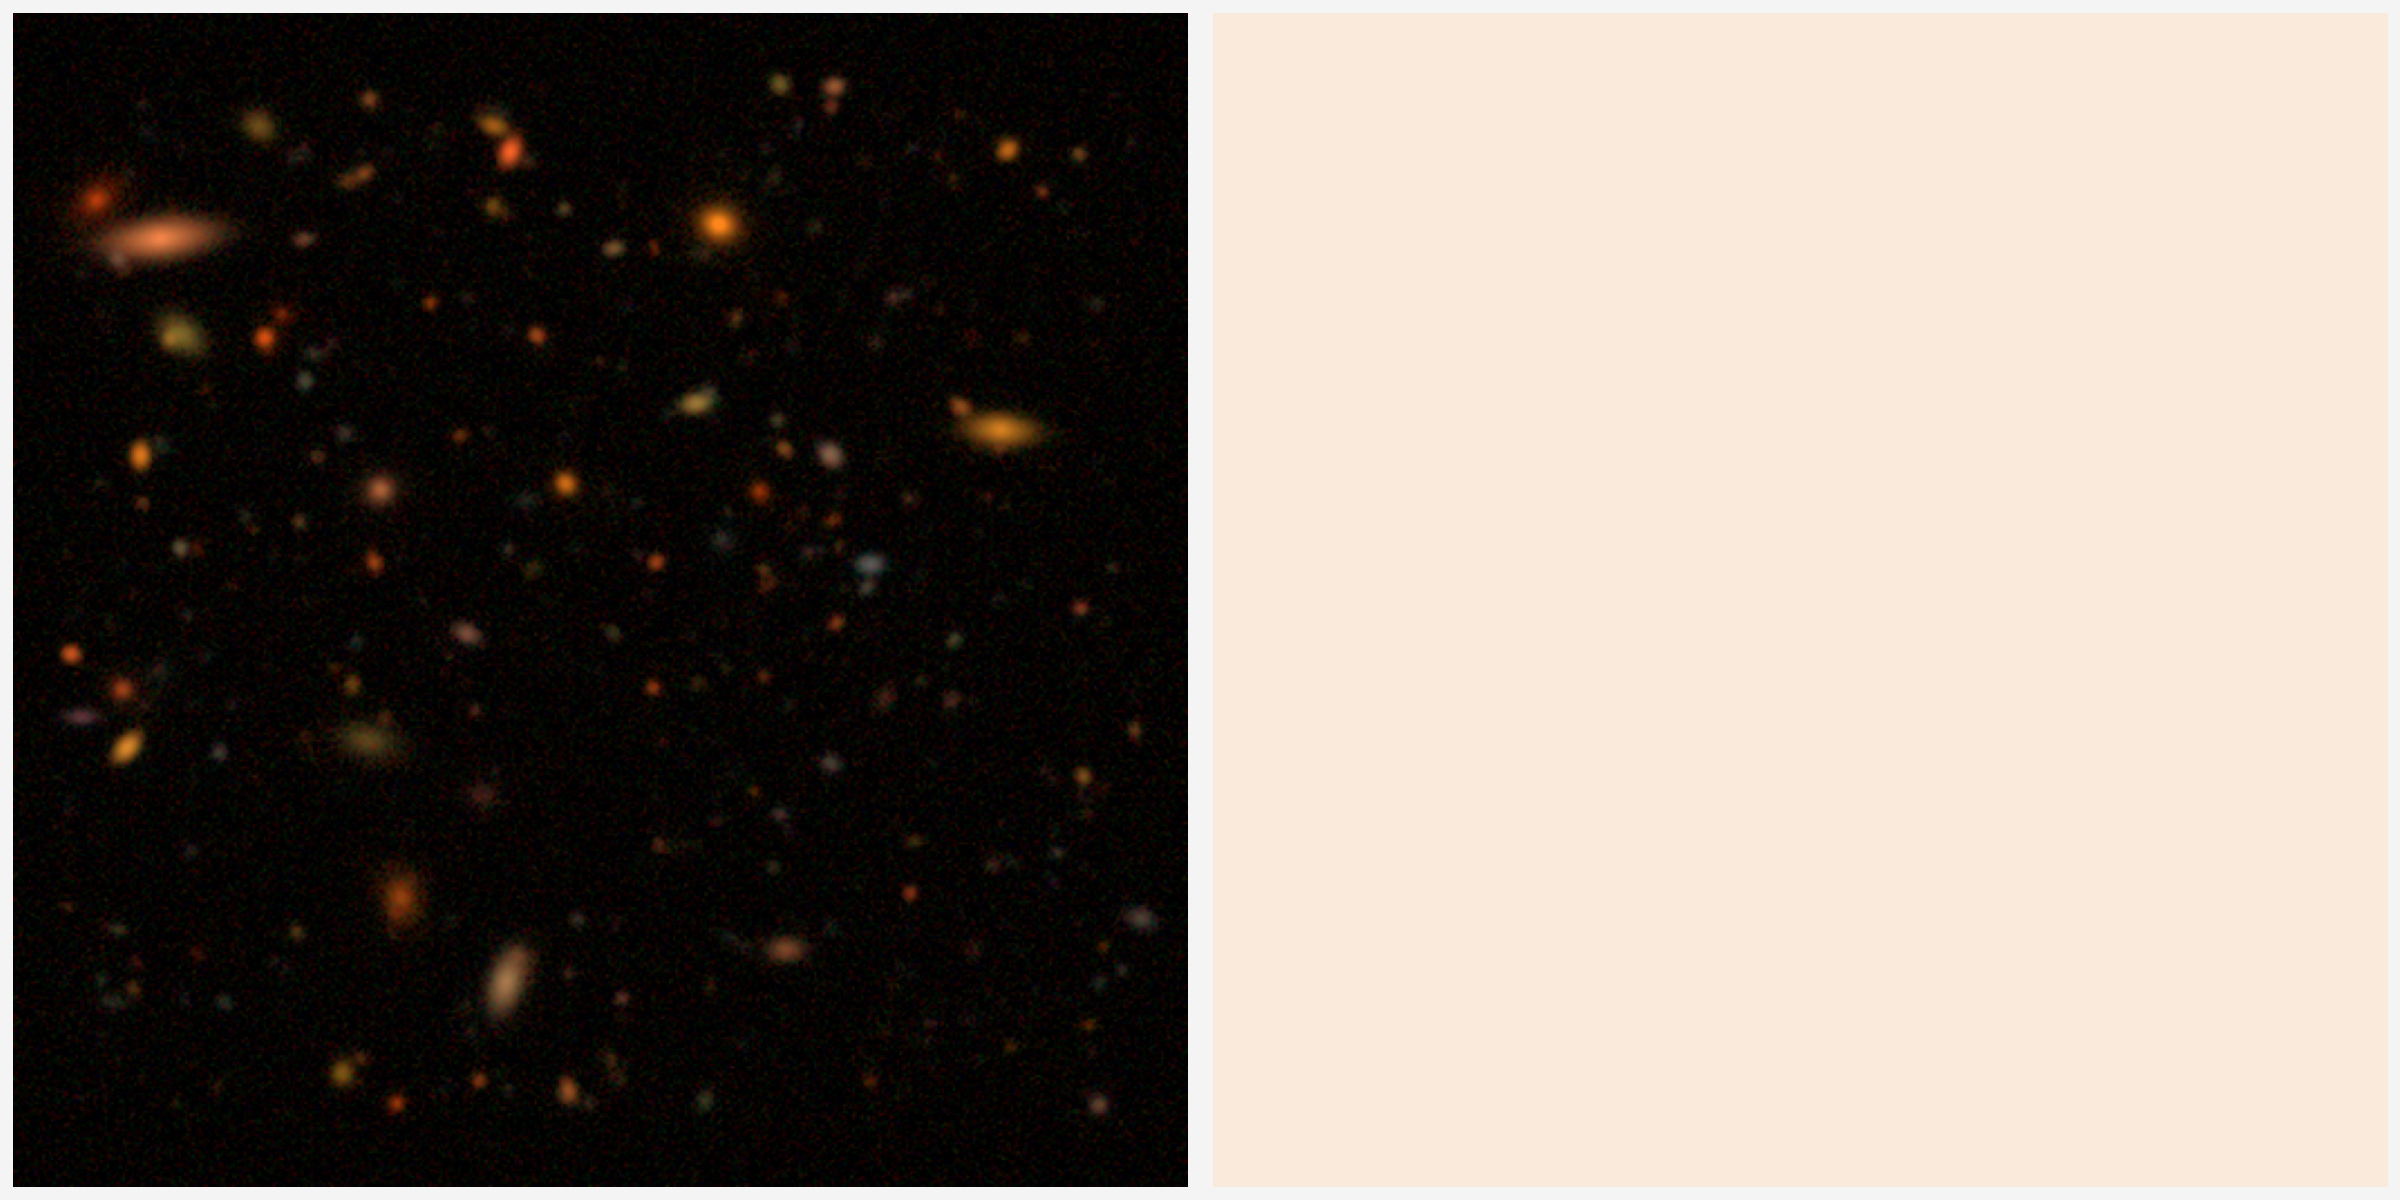

In [12]:
from desimage.images import get_color_image

dim = results["g"]["coadd"]["image"].shape[0]

nonlinear = 0.125

scale = 1e-4
relative_scales = np.array([1.5, 1.0, 1.0])
scales = scale * relative_scales
for i, exptime in enumerate([5520, 5520, 2400]):
     scales[i] *= np.sqrt(5520 / exptime)

colorim = np.zeros((dim, dim, 3), dtype="f4")

get_color_image(
    results["i"]["coadd"]["image"],
    results["r"]["coadd"]["image"],
    results["g"]["coadd"]["image"],
    nonlinear, scales, colorim
)

fig, axs = pplt.subplots(nrows=1, ncols=2, share=0, figsize=(12, 6))
axs[0].imshow(colorim)
axs[0].grid(False)
axs[0].axis("off")
                         
axs[1].imshow(cdata["mfrac"], cmap="rocket_r")
axs[1].grid(False)
axs[1].axis("off")

In [ ]:
fig, axs = pplt.subplots()
axs.hist(cdata["mfrac"].ravel(), log=True)

In [ ]:
fig, axs = pplt.subplots(nrows=2, ncols=3, share=0)
for i, b in enumerate("i"):
    ax = axs[:, i]
    ax[0].imshow(np.arcsinh(data["img"][0]), cmap="rocket")
    # ax[1].imshow(np.arcsinh(results[b]["coadd"]["image"]), cmap="rocket")